In [92]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import os, glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix


from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, average_precision_score
from sklearn.metrics import recall_score, f1_score, precision_score, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp

np.random.seed(1234)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [93]:
def get_savings(predictions, y_true, detail=0):
    '''
    detail: 0 -> show all information
            1 -> show conf_matrix, heatmap, savings
            2 -> show heatmap and savings
    '''
    
    f1 = f1_score(y_true, predictions, average="macro")
    precision = precision_score(y_true, predictions, average="macro")
    recall = recall_score(y_true, predictions, average="macro")
    conf_mat = confusion_matrix(y_true, predictions)

    if detail == 1 or detail == 0:
        if detail == 0:
            print('F1 =',f1)
            print('Precision =',precision)
            print('Recall =', recall)
        print('confusion matrix\n', conf_mat)
    
    cost_matrix = [[0.05, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2],
                   [-0.25, 1, -0.3, -0.1, -0.1, -0.1, -0.1],
                   [-0.02, -0.1, 1, -0.1, -0.1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, 1, -0.1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, 1, -0.1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, -0.1, 1, -0.1],
                   [-0.25, -0.1, -0.3, -0.1, -0.1, -0.1, 1]]

    savings = np.multiply(cost_matrix, conf_mat)
    max_savings = np.sum(np.multiply(cost_matrix,  confusion_matrix(y_true, y_true)))
    
    # set [0][0] to 2nd highest value to get better heatmap and plot the heatmap
    heat = np.copy(conf_mat)
    ind = np.argpartition(heat.max(1), -2)[-2:][0]
    heat[0,0] = heat.max(1)[ind]
    sns.heatmap(heat,cmap=plt.cm.CMRmap_r)
    plt.show()
    
    print('max savings: ', max_savings)
    print('savings: ', np.sum(savings), '\n')

In [4]:
labels = pd.read_csv('./trainset_python/reduced_dataset/labels_50.cvs')
files = pd.read_csv('./trainset_python/reduced_dataset/files_chosen_50.cvs')

In [5]:
files = files.drop(files.columns[[0]], axis=1)

In [6]:
files

,zcr_mean,raw_melspect_mean_4,raw_melspect_mean_5,raw_melspect_mean_6,raw_melspect_mean_7,raw_melspect_mean_8,raw_melspect_mean_9,raw_melspect_mean_10,raw_melspect_mean_11,raw_melspect_mean_12,...,raw_contrast_mean_3,cln_flatness_mean,cln_centroid_mean,cln_centroid_std,cln_flux_mean,cln_flux_std,cln_energy_std,cln_bandwidth_mean,cln_contrast_mean_3,cln_contrast_mean_4
0,0.167208,0.413676,0.351911,0.182678,-0.001713,-0.367584,-0.493130,-0.811764,-0.494151,-0.535799,...,-0.193519,0.623446,0.948781,-0.596810,-0.447192,-0.487065,-0.443302,-0.147406,-1.066098,-1.427318
1,0.461319,-0.855740,0.033231,-0.059496,-0.188944,-0.213440,0.041397,0.137262,0.020711,-0.150333,...,-0.444102,0.947370,0.847815,-0.609965,-0.548157,-0.530030,-0.363591,-0.271310,-1.044733,-0.224404
2,0.854948,0.191515,-0.750290,-0.783740,-0.732563,-0.692779,-0.414533,-1.120994,-0.896223,-0.951161,...,-0.664926,0.872882,1.227718,-0.055447,-0.612837,-0.637614,-0.269222,0.188035,-0.305408,-0.778076
3,0.822960,-0.165756,0.174313,-0.412357,-0.677561,-0.748280,-0.769436,-1.669452,-2.492285,-0.867254,...,-0.219770,1.150775,1.022415,-0.495100,-0.791180,-0.688336,-0.372902,0.320006,-0.382392,-1.623868
4,1.185489,0.244198,-0.320617,-0.825520,-0.931514,-0.686089,-1.062352,-1.561100,-0.029832,0.035515,...,-0.886440,0.438736,0.705754,-0.851836,-0.672211,-0.523607,-0.303215,0.116443,-0.754747,-0.204925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99743,-0.331513,0.688131,0.232498,-0.014584,0.781043,0.300814,0.781700,0.192967,-0.249391,-0.527454,...,-0.038263,0.313846,0.071795,-0.097555,-0.234323,-0.194769,-0.096655,0.412820,-0.184484,-0.286449
99744,-1.220233,1.402616,0.555731,-0.039212,0.328129,0.012447,0.277539,0.595299,0.264265,0.057460,...,-0.348975,0.149666,0.010778,-0.007063,-0.287017,-0.225641,-0.185162,1.113627,0.169436,0.024849
99745,-0.438986,0.461479,0.801244,0.357578,-0.329339,-0.725959,-0.480579,-0.321559,-0.241697,0.001902,...,-0.236202,0.280166,-0.123845,-0.243513,-0.284446,-0.230821,-0.306870,0.845862,-0.368649,0.102378
99746,-0.856478,-0.305130,-0.579203,-0.303088,-0.088837,0.512104,0.852607,0.421025,-0.099590,-0.649966,...,-0.322785,0.151287,-0.175674,-0.153192,-0.281631,-0.204688,-0.181617,0.901573,-0.186372,-0.584563


In [7]:
labels = labels.drop(labels.columns[[0]], axis=1)

In [8]:
labels

,overall_class_vote,class_vote_1,class_vote_2,class_vote_3,class_vote_4,class_vote_5,class_vote_6,class_vote_7
0,0,0,0,0,0.0,0.0,0.0,NaN
1,0,0,0,0,0.0,0.0,0.0,NaN
2,0,0,0,0,0.0,0.0,0.0,NaN
3,0,0,0,0,0.0,0.0,0.0,NaN
4,0,0,0,0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
99743,0,0,0,0,0.0,0.0,0.0,NaN
99744,0,0,0,0,0.0,0.0,0.0,NaN
99745,0,0,0,0,0.0,0.0,0.0,NaN
99746,0,0,0,0,0.0,0.0,0.0,NaN


In [9]:
X_train, X_test, y_train, y_test = train_test_split(files,labels['overall_class_vote'],test_size = 0.2,stratify=labels['overall_class_vote'], random_state=42)

In [21]:
svm_rbf_classifier = svm.SVC(kernel='rbf', random_state=42, cache_size=1024, probability=True)

svm_rbf_classifier.fit(X_train,y_train)
# make prediction 
preds_svm = svm_rbf_classifier.predict(X_test) 
# check performance
accuracy_score(preds_svm,y_test)

0.8831578947368421

In [11]:
# save model
import pickle

#os.makedirs('models')

In [23]:
pickle.dump(svm_rbf_classifier, open('model_rbf', 'wb'))

F1 = 0.7859422007945971
Precision = 0.8724014974689452
Recall = 0.721549126684318
confusion matrix
 [[13273    24    37    45     2    39    25]
 [  244   787     5    63     1     2     0]
 [  414    15  1088   182     7     6     2]
 [  349    40   148   977     3    12     5]
 [   72     7    41    20   292     5     2]
 [  302     3     3     4     4   625    14]
 [  144    10     2     5     0    23   577]]


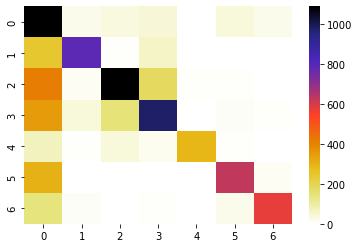

max savings:  7177.25
savings:  4586.02 



In [30]:
get_savings(preds_svm, y_test)

In [12]:
loaded_model = pickle.load(open('./models/model_rbf', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8831578947368421


Classifier with kernel=rbf, C=0.01 -> accuracy = 0.7499749373433584


c:\Users\Sandro\anaconda3\envs\ho2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


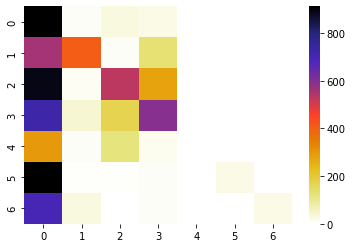

max savings:  7177.25
savings:  1276.8600000000006 

None
-----------

Classifier with kernel=rbf, C=0.5 -> accuracy = 0.8698245614035087


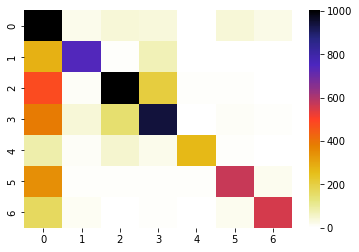

max savings:  7177.25
savings:  4271.68 

None
-----------

Classifier with kernel=rbf, C=1.5 -> accuracy = 0.8897243107769424


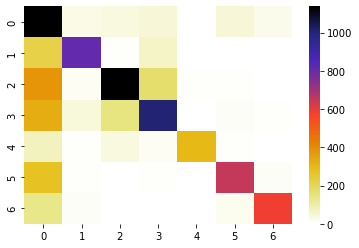

max savings:  7177.25
savings:  4754.089999999999 

None
-----------

Classifier with kernel=rbf, C=2 -> accuracy = 0.8934335839598998


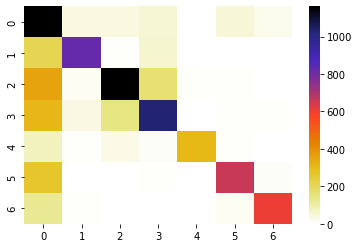

max savings:  7177.25
savings:  4855.710000000001 

None
-----------

Classifier with kernel=rbf, C=4 -> accuracy = 0.8996491228070176


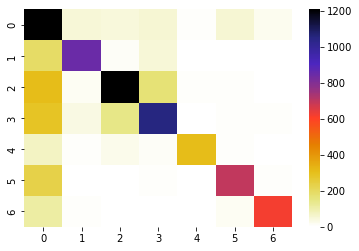

max savings:  7177.25
savings:  5023.83 

None
-----------



In [17]:
from sklearn.model_selection import cross_validate,  StratifiedKFold
from sklearn.metrics import average_precision_score, make_scorer

ap = make_scorer(average_precision_score)


svm_dict = {
    'kernel': ['rbf'],
    'C': [0.01, 0.5, 1.5, 2, 4]
}

cross_validation = StratifiedKFold(n_splits=5)
accs_train = []
accs_cv = []

for kernel in svm_dict['kernel']:
    for C in svm_dict['C']:
        classifier = svm.SVC(kernel=kernel, C=C, random_state=42, cache_size=5120, probability=True)
        classifier.fit(X_train, y_train)

        pickle.dump(classifier, open(f'models/model_rbf_C_{C}', 'wb'))
        # make prediction
        pred = classifier.predict(X_test)
        print(f'Classifier with kernel={kernel}, C={C} -> accuracy = {accuracy_score(pred, y_test)}')
        print(get_savings(pred, y_test, 2))
        print('-----------\n')

0.8037593984962406


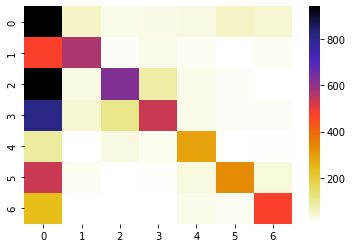

max savings:  7177.25
savings:  2789.0299999999997 

None


In [14]:
loaded_model = pickle.load(open('./models/model_poly_degree_7', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

preds_svm = loaded_model.predict(X_test) 
print(get_savings(preds_svm, y_test, 2))

0.7878195488721804


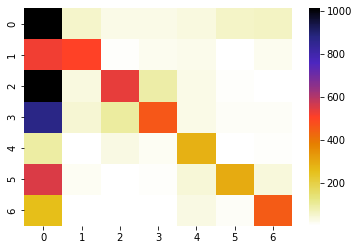

max savings:  7177.25
savings:  2458.3900000000003 

None


In [15]:
loaded_model = pickle.load(open('./models/model_poly_degree_9', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

preds_svm = loaded_model.predict(X_test) 
print(get_savings(preds_svm, y_test, 2))

0.7749874686716792


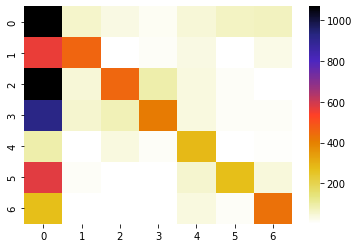

max savings:  7177.25
savings:  2182.29 

None


In [16]:
loaded_model = pickle.load(open('./models/model_poly_degree_11', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

preds_svm = loaded_model.predict(X_test) 
print(get_savings(preds_svm, y_test, 2))

In [13]:
with open('trainset_python/python/feature_names.txt') as f:
    features = f.readlines()

for i,feature in enumerate(features):
    features[i] = feature.strip()

In [16]:
test_data = []
rootdir = os. getcwd()

for i,f in enumerate(glob.glob('../testset_python/python/*.npy', recursive=True)):
    file_stand = pd.DataFrame(StandardScaler().fit_transform(np.load(f)), columns = features)
    test_data.append(file_stand)
    
test_data = np.array(test_data)

In [17]:
test_data.shape

(16, 3000, 548)

[0.8831578947368421, 0.7499749373433584, 0.8698245614035087, 0.8897243107769424, 0.8934335839598998, 0.8996491228070176]


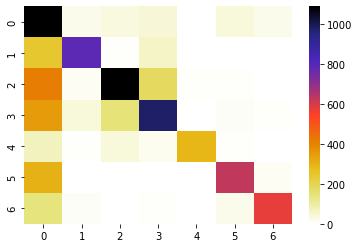

max savings:  7177.25
savings:  4586.02 

None


C:\Users\Sandro\anaconda3\envs\ho2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


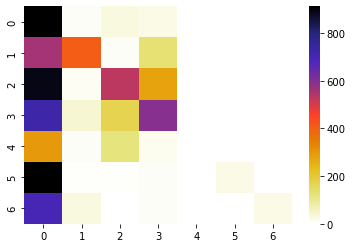

max savings:  7177.25
savings:  1276.8600000000006 

None


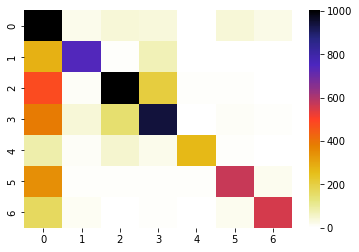

max savings:  7177.25
savings:  4271.68 

None


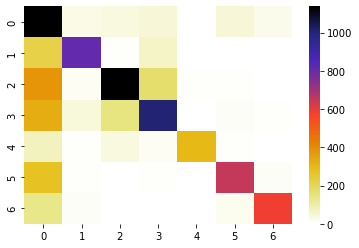

max savings:  7177.25
savings:  4754.089999999999 

None


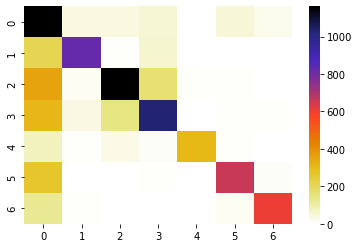

max savings:  7177.25
savings:  4855.710000000001 

None


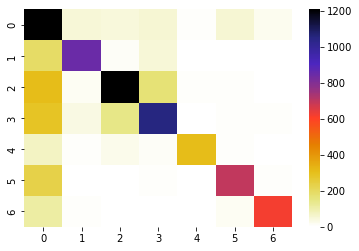

max savings:  7177.25
savings:  5023.83 

None


In [18]:
loaded_model_rbf_C_10 = pickle.load(open('./models/model_rbf', 'rb'))
loaded_model_rbf_C_001 = pickle.load(open('./models/model_rbf_C_0.01', 'rb'))
loaded_model_rbf_C_05 = pickle.load(open('./models/model_rbf_C_0.5', 'rb'))
loaded_model_rbf_C_15 = pickle.load(open('./models/model_rbf_C_1.5', 'rb'))
loaded_model_rbf_C_20 = pickle.load(open('./models/model_rbf_C_2', 'rb'))
loaded_model_rbf_C_40 = pickle.load(open('./models/model_rbf_C_4', 'rb'))

results = []
results.append(loaded_model_rbf_C_10.score(X_test, y_test))
results.append(loaded_model_rbf_C_001.score(X_test, y_test))
results.append(loaded_model_rbf_C_05.score(X_test, y_test))
results.append(loaded_model_rbf_C_15.score(X_test, y_test))
results.append(loaded_model_rbf_C_20.score(X_test, y_test))
results.append(loaded_model_rbf_C_40.score(X_test, y_test))

print(results)

preds_svm = []

preds_svm.append(loaded_model_rbf_C_10.predict(X_test))
preds_svm.append(loaded_model_rbf_C_001.predict(X_test))
preds_svm.append(loaded_model_rbf_C_05.predict(X_test))
preds_svm.append(loaded_model_rbf_C_15.predict(X_test))
preds_svm.append(loaded_model_rbf_C_20.predict(X_test))
preds_svm.append(loaded_model_rbf_C_40.predict(X_test))

for pred_svm in preds_svm:
    print(get_savings(pred_svm, y_test, 2))

In [21]:
selected_features_50 = X_train.columns

In [22]:
selected_features_50

Index(['zcr_mean', 'raw_melspect_mean_4', 'raw_melspect_mean_5',
       'raw_melspect_mean_6', 'raw_melspect_mean_7', 'raw_melspect_mean_8',
       'raw_melspect_mean_9', 'raw_melspect_mean_10', 'raw_melspect_mean_11',
       'raw_melspect_mean_12', 'raw_mfcc_mean_0', 'raw_mfcc_mean_1',
       'raw_mfcc_mean_2', 'raw_mfcc_mean_6', 'raw_mfcc_mean_7',
       'raw_mfcc_mean_8', 'raw_mfcc_mean_9', 'raw_mfcc_mean_10',
       'raw_mfcc_mean_11', 'raw_mfcc_mean_12', 'raw_mfcc_mean_13',
       'raw_mfcc_mean_14', 'raw_mfcc_mean_15', 'raw_mfcc_mean_16',
       'raw_mfcc_mean_17', 'raw_mfcc_std_0', 'raw_mfcc_std_1',
       'raw_mfcc_d_mean_0', 'raw_mfcc_d_mean_1', 'raw_mfcc_d_std_0',
       'raw_flatness_mean', 'raw_flatness_std', 'raw_centroid_mean',
       'raw_flux_mean', 'raw_flux_std', 'raw_energy_mean', 'raw_energy_std',
       'raw_power_mean', 'raw_power_std', 'raw_bandwidth_mean',
       'raw_contrast_mean_3', 'cln_flatness_mean', 'cln_centroid_mean',
       'cln_centroid_std', 'cln_flu

In [23]:
test_data_50 = []

for i,file in enumerate(test_data):
    file_50 = pd.DataFrame()
    for idx in selected_features_50:
        file_50[idx] = file[idx]
    test_data_50.append(file_50)
    
    if i < 10:
        file_50.to_csv('data_test_temp/file_train_50_0' + str(i) + '.csv', index=False)
    else:
        file_50.to_csv('data_test_temp/file_train_50_' + str(i) + '.csv', index=False)

    
test_data_50[0] 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [27]:
data_test_50 = []
for i in range(10):
    data_test_50.append(pd.read_csv('data_test_temp/file_train_50_0' + str(i)))
for i in range(10,16):
    data_test_50.append(pd.read_csv('data_test_temp/file_train_50_' + str(i)))
data_test_50 = np.array(data_test_50)

In [29]:
data_test_50.shape

(16, 3000, 50)

In [38]:
def postprocess(preds):
    preds_post = np.copy(preds)
    i_max = len(preds_post)
    for i,c in enumerate(preds_post):
        
        # what to do with first prediction?
        if i == 0:
            pass
        
        # 
        if i > 0 and i < i_max-1:
            if preds_post[i-1] == 2 and i > 1 and i < i_max-2:
                if preds_post[i-2] == preds_post[i+2]:
                    preds_post[i] = preds_post[i-1]
        
            # case yny flip to yyy, important to do before nyn to nnn
            if preds_post[i-1] == preds_post[i+1] and preds_post[i-1] != 0:
                preds_post[i] = preds_post[i-1]
                       
            # case nnynn flip to nnnnn if class not grswoo (because they have short calls)
            if  i > 1 and i < i_max-2:
                if preds_post[i-2] == preds_post[i-1] == preds_post[i+1] == preds_post[i+2] and preds_post[i] != 5:
                    preds_post[i] = preds_post[i-1]

            
        '''
        if i > 1 and i < len(preds_post)-2:
            if preds_post[i-2] == preds_post[i-1] == preds_post[i+1] == preds_post[i+2]:
                preds_post[i] = preds_post[i-1]
        '''
    return preds_post

In [96]:
from csv import writer
import datetime

classifier = pickle.load(open('./models/model_rbf_C_4', 'rb'))

curr_time = str(datetime.datetime.now())
curr_time = curr_time.replace(':', '_')
curr_time = curr_time.replace('.', '_')

non_sequences = []
post_sequences = []

with open(f'Predictions/Prediction_post_{curr_time}.csv', 'w', newline='') as file:
    writer_object = writer(file)
    for i,test in enumerate(data_test_50):
        chall_preds = classifier.predict(test)
        non_sequences.append(chall_preds)
        #print(f'file:{i}: {chall_preds}')
        chall_preds_post = chall_preds
        #chall_preds_post = postprocess(chall_preds)
        #post_sequences.append(chall_preds_post)
        
        if i < 10:
            lis_t = ['test0' + str(i)]
            for value in chall_preds_post:
                lis_t.append(str(value))
            writer_object.writerow(lis_t)
        else:
            lis_t = ['test' + str(i)]
            for value in chall_preds_post:
                lis_t.append(str(value))
            writer_object.writerow(lis_t)
    file.close()

C:\Users\Sandro\anaconda3\envs\ho2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Sandro\anaconda3\envs\ho2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Sandro\anaconda3\envs\ho2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Sandro\anaconda3\envs\ho2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Sandro\anaconda3\envs\ho2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Sandro\anaconda3\envs\ho2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have va

In [80]:
import matplotlib.pyplot as plt

def visualize_sequences(non_seq, post_seq, true_seq=[], first_n=500):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,15))
    
    #ax[0].title('Raw predictions')
    ax[0].set_xlim(0, first_n)  
    ax[0].set_ylim(0, 5)  
    
    #ax[1].title('Post_processing predictions')
    ax[1].set_xlim(0, first_n)  
    ax[1].set_ylim(0, 5)  
    
    if true_seq != []:
        #ax[1].title('Post_processing predictions')
        ax[2].set_xlim(0, first_n)  
        ax[2].set_ylim(0, 5)  
        
        for i, num in enumerate(true_seq[:first_n]):
            ax[2].plot([i, i], [0, num], color='blue') 

    for i, num in enumerate(non_seq[:first_n]):
        ax[0].plot([i, i], [0, num], color='blue') 
        
    for i, num in enumerate(post_seq[:first_n]):
        ax[1].plot([i, i], [0, num], color='blue') 

    plt.show()

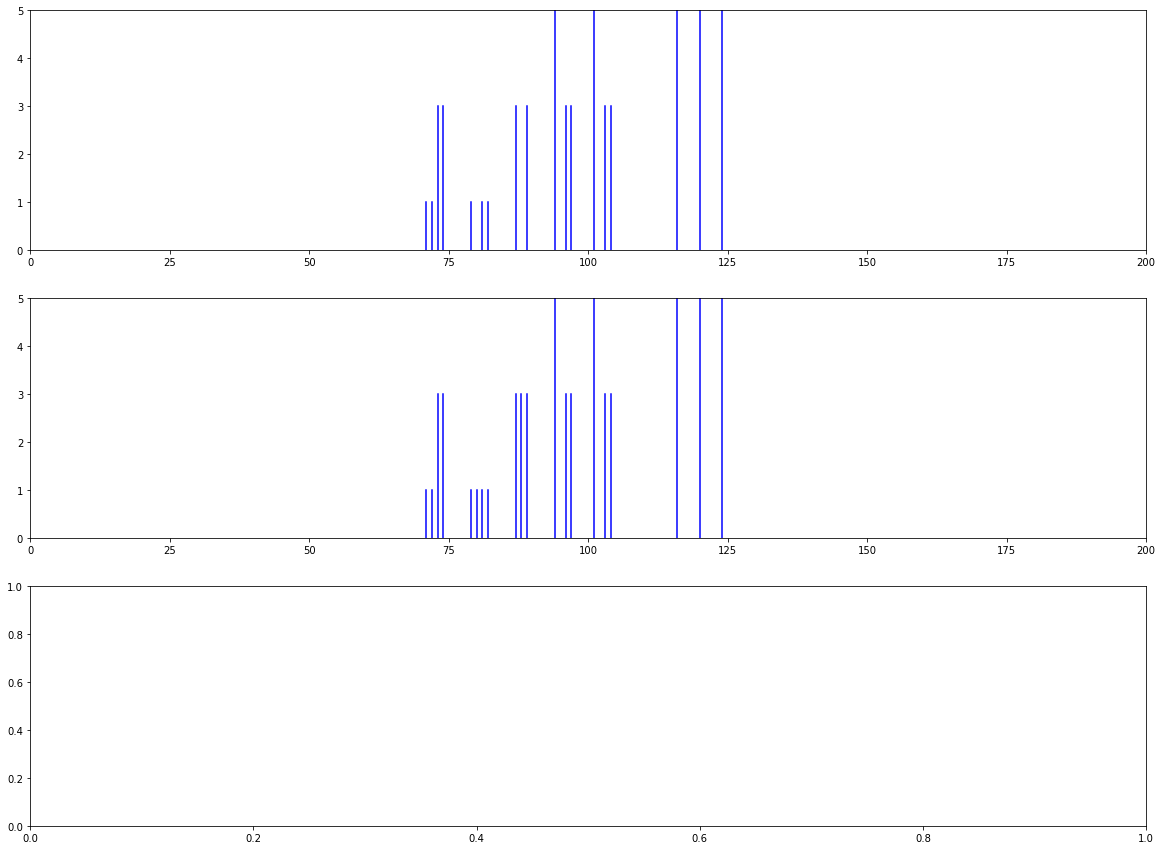

In [74]:
visualize_sequences(non_sequences[0], post_sequences[0], first_n=200)

In [75]:
loaded_model = pickle.load(open('./models/model_rbf_C_4', 'rb'))

preds_svm = loaded_model.predict(X_test) 
print(preds_svm)

[3 0 0 ... 0 0 2]


In [76]:
preds_svm_post = postprocess(preds_svm)
print(pred_svm)

[3 0 0 ... 0 0 2]


In [77]:
print(np.array(y_test))

[2 0 0 ... 0 0 2]


C:\Users\Sandro\AppData\Local\Temp\ipykernel_8104\2228357094.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if true_seq != []:


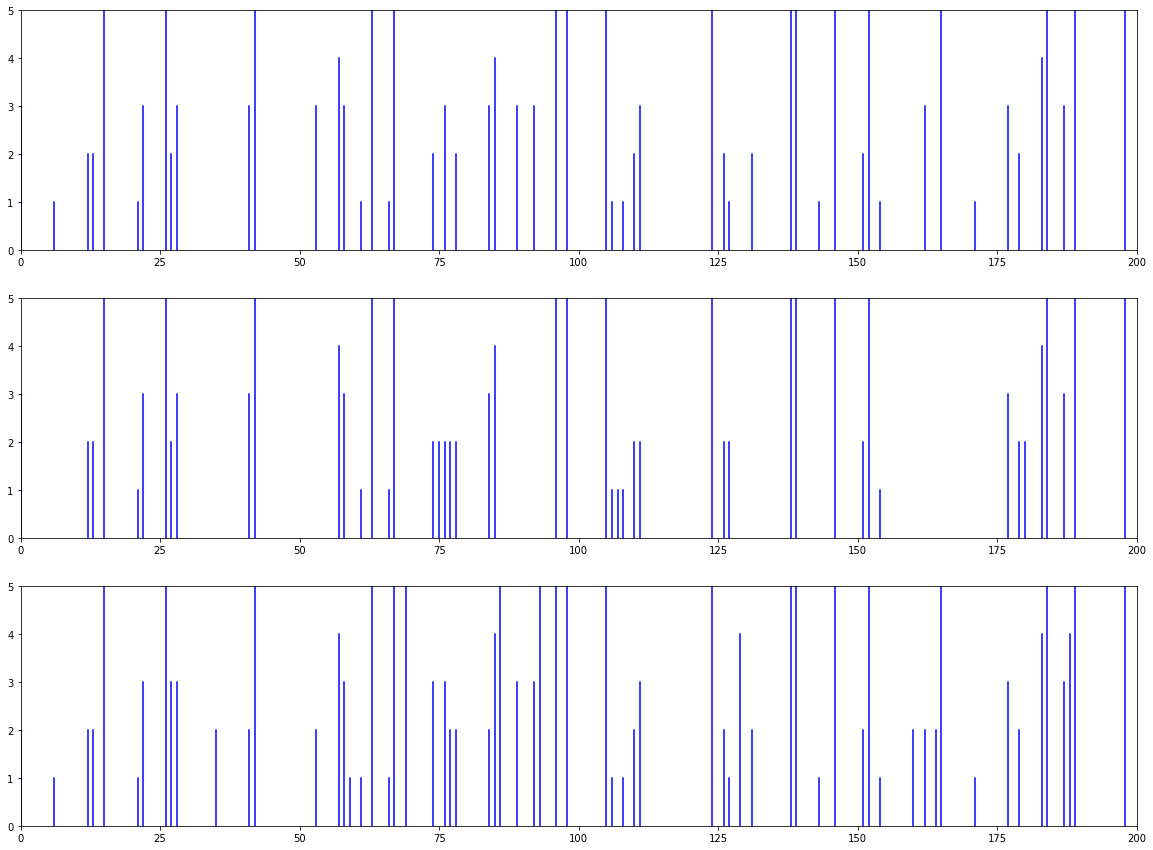

In [81]:
visualize_sequences(preds_svm, preds_svm_post, np.array(y_test), first_n=200)

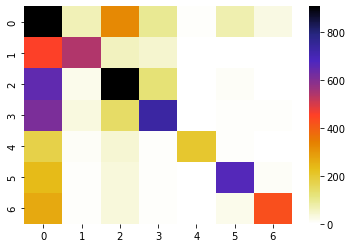

max savings:  7177.25
savings:  3427.85 



In [94]:
import numpy as np
get_savings(preds_svm_post, y_test, 2)

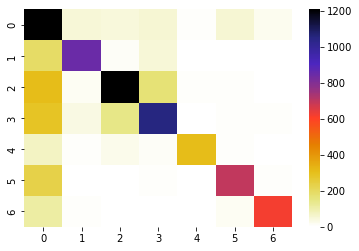

max savings:  7177.25
savings:  5023.83 



In [95]:
get_savings(pred_svm, y_test, 2)